In [2]:
import datetime
import xarray
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os
import pandas as pd
import geopandas
import json
import seaborn
import hsman

from pyeosim.atmosphere import LUT_from_file
from pyeosim.datasets import DATA_PATHS
from pyeosim.plot import rgb
import pyeosim

def read_atmos_meta(path):
    jsons = os.listdir(path)
    jsons = [x for x in os.listdir(atmos_path) if x.endswith('json')]
    metas = {}
    for _json in jsons:
        with open(os.path.join(path, _json), 'r') as f:
            metas[_json.split('.')[0]] = json.load(f)
    return pd.DataFrame(metas).T

poundfarm_rgb = hsman.open_dataset('ECLS1201706193_RGB_aerial')
poundfarm = hsman.open_dataset('ECLS1201706193_VNIR_aerial')
roi = geopandas.read_file('treeview_roi.gpkg').to_crs(poundfarm.crs).iloc[0]['geometry']

/STEM/data/project/users/jf9942/anaconda3/envs/hsman2/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [4]:
[127, 73, 29]

[127, 73, 29]

In [115]:
cor_1 = np.atleast_3d([.05, .5, 1]).transpose([1,0,2])
cor_2 = np.atleast_3d([.4,.5,1]).transpose([1,0,2])

In [116]:
# min max
xmin = np.min(roi.exterior.xy[0])+40
xmax = np.max(roi.exterior.xy[0])-50
ymin = np.min(roi.exterior.xy[1])
ymax = np.max(roi.exterior.xy[1])-50

fpath = DATA_PATHS['TEST_HSI_LARGE']
ds_mk = xarray.open_dataset(fpath).Reflectance
ds_pf = poundfarm.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))
# rgb_pf = rgb(np.atleast_3d([1, .6, .8]).transpose([1,0,2]) * ds_pf.isel(band=[70,40,20]).fillna(0), return_array=True)
rgb_pf = rgb(cor_1 * ds_pf.sel(band=[127, 73, 29]).fillna(0), return_array=True)[:362, -362:]
rgb_pf = rgb_pf.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

# rgb_mk = rgb(ds_mk.isel(band=[70,40,20]), return_array=True)
rgb_mk = rgb(cor_2 * ds_mk.isel(band=[127, 73, 29]), return_array=True)
ds_mk = ds_mk.swap_dims({'band':'wavelength'})
ds_mk = ds_mk.sel(wavelength=slice(400,898)).astype(float)/10000
ds_pf = ds_pf.swap_dims({'band':'wavelength'})#[:, 100:462, 100:462]
ds_pf = ds_pf.sel(wavelength=slice(400,898)).astype(float)/10000

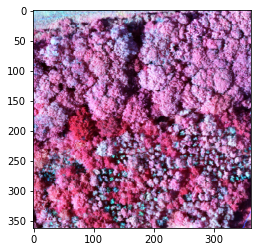

In [117]:
plt.imshow(rgb_pf)

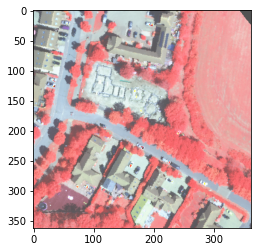

In [118]:
plt.imshow(rgb_mk.values)

In [8]:
atmos_path = 'atmospheres/atmospheres_2/'
atmos_meta = read_atmos_meta(atmos_path)

In [9]:
atmos = LUT_from_file(atmos_path, {
    'view_z': 0,
    'view_a': 0
})
# atmos = Test6S()
# # generate Top of Atmosphere images
atmos.LUT = atmos.LUT.sel(scenario='mk_20200622_1200_nadir')

In [10]:
toa_mk = atmos.transform(ds_mk).compute()
toa_pf = atmos.transform(ds_pf).compute()

In [11]:
import yaml
from pyeosim.sensor import TCMOS_test, TeledyneCMOS
sensor_configs = yaml.load(open('sensors.yaml', 'r'), Loader=yaml.Loader)

In [12]:
s2_sensor = TeledyneCMOS(ground_sample_distance=10,
                         psf_fwhm=21,
                         spectral_response=pyeosim.spectral.Sentinel2A(),
                         lens_diameter=.01,
                         prnu_factor=0,
                         ccd_vref=1,sense_node_gain=2,
                         dark_factor=0,
                         dark_current=0,
                         offset_factor=0,)

In [13]:
# PAN_sensor = TeledyneCMOS(**sensor_configs['TreeView_3_PAN_64'])
MSI_sensor = TeledyneCMOS(**sensor_configs['TreeView_3_MSI_32'])
# sim_mk_PAN = PAN_sensor.fit_transform(toa_mk)
sim_mk_MSI = MSI_sensor.fit_transform(toa_mk)
# sim_pf_PAN = PAN_sensor.transform(toa_pf)
sim_pf_MSI = MSI_sensor.transform(toa_pf)

# sentinel 2
sim_pf_s2 = s2_sensor.fit_transform(toa_pf)
sim_mk_s2 = s2_sensor.fit_transform(toa_mk)

In [15]:
sim_pf_MSI.band_name

<xarray.DataArray 'band_name' (band: 8)>
array(['Aerosol', 'PRI_1', 'PRI_2', 'Chlorophyll_1', 'Chlorophyll_2',
       'RedEdge_2', 'RedEdge_3', 'NIR'], dtype='<U13')
Coordinates:
    scenario   <U22 'mk_20200622_1200_nadir'
  * band       (band) int64 0 1 2 3 4 5 6 7
    band_name  (band) <U13 'Aerosol' 'PRI_1' 'PRI_2' ... 'RedEdge_3' 'NIR'

In [16]:
sim_pf_s2.band_name

<xarray.DataArray 'band_name' (band: 8)>
array(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A'], dtype='<U3')
Coordinates:
  * band       (band) int64 0 1 2 3 4 5 6 7
    scenario   <U22 'mk_20200622_1200_nadir'
    band_name  (band) <U3 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B8A'

In [85]:
cor_3 = np.atleast_3d([.2, 1, 1]).transpose([1,0,2])
cor_4 = np.atleast_3d([1, .6, 1]).transpose([1,0,2])

In [112]:
tv_pf_falsecolor = rgb(cor_3 * sim_pf_MSI.isel(band=[7,4,2]), return_array=True)[:61, -61:]
s2_pf_falsecolor = rgb(cor_4 * sim_pf_s2.isel(band=[7,2,1]), return_array=True)[:12,-12:]
tv_mk_falsecolor = rgb(cor_4 * sim_mk_MSI.isel(band=[7,4,2]), return_array=True)
s2_mk_falsecolor = rgb(cor_4 * sim_mk_s2.isel(band=[7,2,1]), return_array=True)

In [113]:
import matplotlib
import copy
import colorcet
# cmap = copy.copy(colorcet.cm.fire)
# cmap.set_under(alpha=1)
# cmap.set_over(alpha=1)
# nipy = copy.copy(matplotlib.cm.get_cmap('nipy_spectral'))
# nipy.set_under(alpha=0)
# nipy.set_over(alpha=0)

# cw = copy.copy(matplotlib.cm.get_cmap('coolwarm'))
cw = copy.copy(colorcet.cm.bmy)
cw.set_under(alpha=1, color='k')

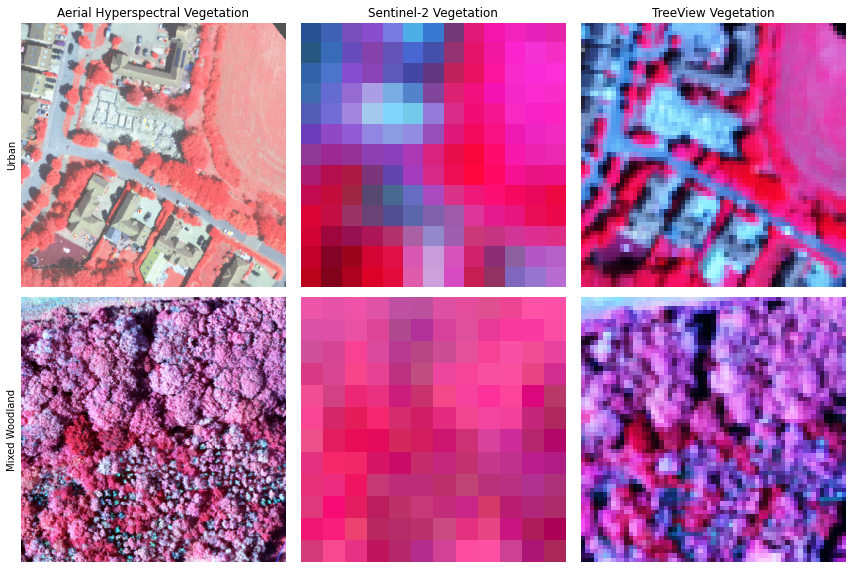

In [121]:
f, axs = plt.subplots(2,3, figsize=(12,8))

axs[0][0].imshow(rgb_mk.values)
axs[1][0].imshow(rgb_pf.values[:362, -362:])

axs[0][1].imshow(s2_mk_falsecolor, interpolation='none')
axs[1][1].imshow(s2_pf_falsecolor, interpolation='none')

axs[0][2].imshow(tv_mk_falsecolor, interpolation='none')
axs[1][2].imshow(tv_pf_falsecolor, interpolation='none')

seaborn.despine(left=True, bottom=True, trim=True)

axs[0][0].set_ylabel('Urban')
axs[1][0].set_ylabel('Mixed Woodland')

axs[0][0].set_title('Aerial Hyperspectral Vegetation')

axs[0][2].set_title('TreeView Vegetation')
axs[0][1].set_title('Sentinel-2 Vegetation')

axs = axs.flat
for a in axs:
    a.set_xticks([])
    a.set_yticks([])
    
plt.tight_layout()
plt.savefig('TreeView_plots/A_general_audience_sims.png', dpi=200)